# Raylegh Taylor instability with Free-Surface: The Drunken sailor effect

![Kaus2010_figure1.png](./Kaus2010_figure1.png)

Rayleigh–Taylor instability of a dense, more viscous layer ($\rho$ = 3300 kg/m3 , $\mu = 1e21$ Pa s), sinking through a less dense fluid ( = 3200 kg/m3 ,  = 1020 Pa s). Side boundaries
are free slip, the lower boundary is no-slip and the upper boundary is a free surface. The box is 500 × 500 km in size, and gravitational acceleration was 9.81 m/s2 . The initial
perturbation was sinusoidal with initial amplitude of 5 km. A constant time step of 2500 years (A) or 5000 years (B) was employed, with Q2 P−1 quadrilateral elements and
51 × 51 nodes. Whereas the 2500 years simulation evolves smoothly, the simulation with t = 5000 years results in a sloshing instability, in which the velocity pattern
changes direction from one time step to the other.

In [1]:
from underworld import UWGeodynamics as GEO
from underworld import visualisation as vis

--------------------------------------------------------------------------
The library attempted to open the following supporting CUDA libraries,
but each of them failed.  CUDA-aware support is disabled.
libcuda.so.1: cannot open shared object file: No such file or directory
libcuda.dylib: cannot open shared object file: No such file or directory
/usr/lib64/libcuda.so.1: cannot open shared object file: No such file or directory
/usr/lib64/libcuda.dylib: cannot open shared object file: No such file or directory
If you are not interested in CUDA-aware support, then run with
--mca opal_warn_on_missing_libcuda 0 to suppress this message.  If you are interested
in CUDA-aware support, then try setting LD_LIBRARY_PATH to the location
of libcuda.so.1 to get passed this issue.
--------------------------------------------------------------------------


loaded rc file /home/romain/PROJECTS/Project_fssa/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

## Scaling

In [3]:
half_rate = 1.0 * u.centimeter / u.year
model_length = 500 * u.km
bodyforce = 3300 * u.kg / u.m**3 * 9.81 * u.m / u.s**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

## Model Geometry

In [4]:
gravity_vector = (0.0, -9.81 * u.m / u.s**2)

In [5]:
Model = GEO.Model(elementRes=(50, 50), 
                  elementType="Q2/dPc1",
                  minCoord=(-250. * u.km, -500. * u.km), 
                  maxCoord=(250. * u.km, 0. * u.km), 
                  gravity=gravity_vector)

	Global element size: 5x5
	Local offset of rank 0: 0x0
	Local range of rank 0: 5x5


In [7]:
import underworld.function as fn

In [8]:
import numpy as np

amplitude = GEO.non_dimensionalise(5*u.km)
period = GEO.non_dimensionalise(Model.length) * 2.0
interface_depth = GEO.non_dimensionalise(100*u.km)
func = -interface_depth + (amplitude * fn.math.cos(2.0*np.pi*fn.input()[0]/period))

shape = fn.input()[1] < -interface_depth + (amplitude * fn.math.cos(2.0*np.pi*fn.input()[0]/period))

In [9]:
HD_material = Model.add_material(name="HD_material", shape=GEO.shapes.Layer(top=Model.top, bottom=Model.bottom))
LD_material = Model.add_material(name="LD_material", shape=shape)


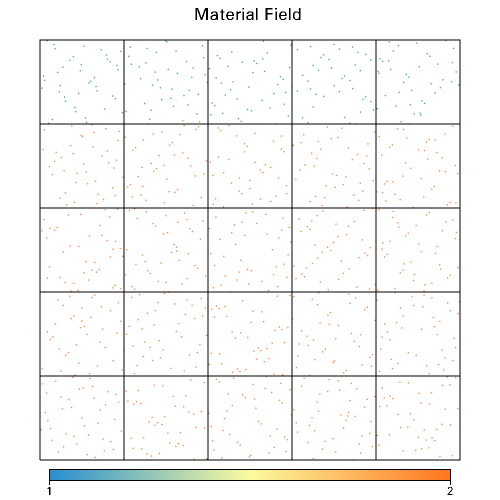

In [10]:
Fig = vis.Figure(figsize=(500,500), title="Material Field", quality=2)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.Mesh(Model.mesh)
Fig.show()

In [11]:
LD_material.density = 3200 * u.kilogram / u.meter**3
HD_material.density = 3300 * u.kilogram / u.meter**3
LD_material.viscosity = 1e20 * u.pascal * u.second
HD_material.viscosity = 1e21 * u.pascal * u.second

## Boundary Conditions

In [12]:
Model.set_kinematicBCs(left=[0., None],
                       right=[0., None],
                       top=[None, None],
                       bottom=[None,0.],
                       order_wall_conditions=[ "top", "left", "right", "bottom"])

In [13]:
Model.freeSurface = True

	Global element size: 5x5
	Local offset of rank 0: 0x0
	Local range of rank 0: 5x5


In [14]:
Model.fssa_factor = 1.0

# Compute initial condition

In [15]:
Model.init_model(pressure="lithostatic")

/home/romain/PROJECTS/Project_fssa/UWGeodynamics/UWGeodynamics/_model.py:1569: UserWarning: Skipping the steady state calculation: No diffusivity variable defined on Model
  warnings.warn("Skipping the steady state calculation: No diffusivity variable defined on Model")



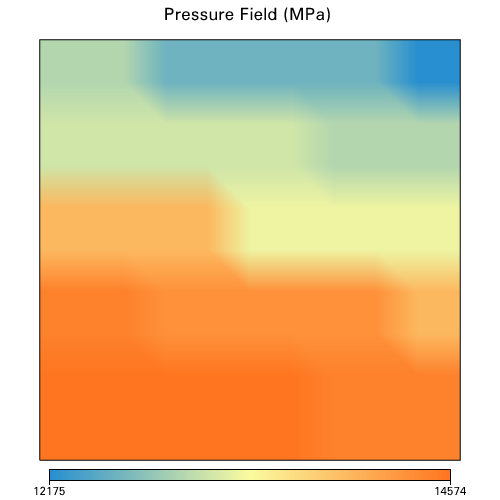

In [16]:
Fig = vis.Figure(figsize=(500,500), title="Pressure Field (MPa)", quality=3)
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.pressureField, u.megapascal))
Fig.show()


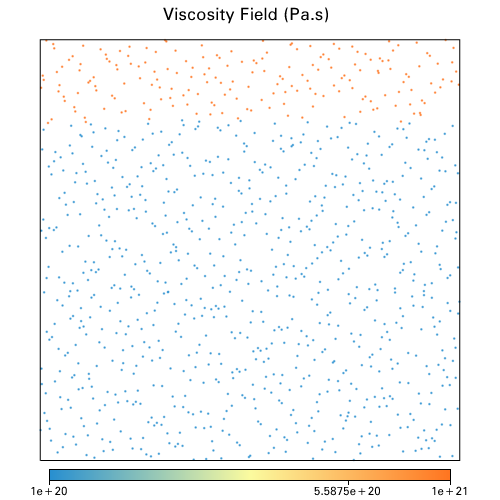

In [17]:
Fig = vis.Figure(figsize=(500,500), title="Viscosity Field (Pa.s)", quality=3)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.viscosityField, u.pascal * u.second),
           logScale=True,
           fn_size=3.0)
Fig.show()


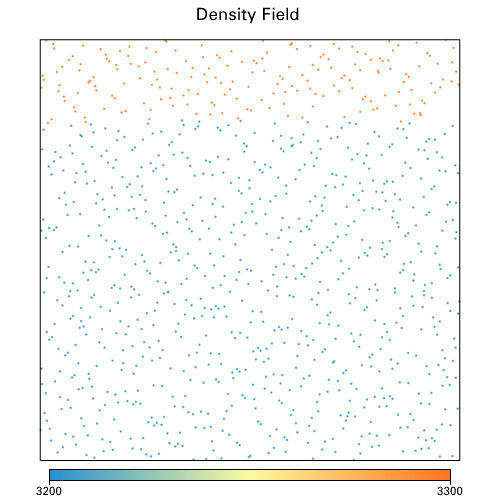

In [18]:
Fig = vis.Figure(figsize=(500,500), title="Density Field", quality=3)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.densityField, u.kg / u.m**3),
           fn_size=3.0)
Fig.show()

## Solver options

In [19]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-4

In [20]:
steps = 1000
test_steps = 20
Model.run_for(nstep=test_steps, checkpoint_interval=1, dt=5000*u.year)

Running with UWGeodynamics version 2.13.0-dev-3b1d4ec(development)
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Linear solver (JAKUE516__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.000611 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0002562 secs / 1 its
  Pressure Solve:         = 0.001286 secs / 5 its
  Final V Solve:          = 0.0001874 secs / 1 its

  Total BSSCR Linear solve time: 0.006478 seconds

Linear solver (JAKUE516__system-execute), solution time 8.233036e-03 (secs

1


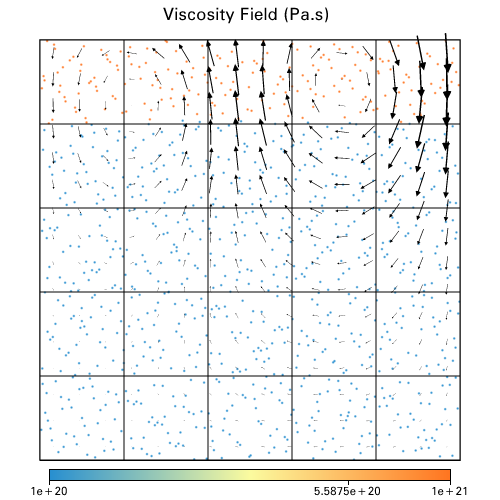

In [22]:
Fig = vis.Figure(figsize=(500,500), title="Viscosity Field (Pa.s)", quality=3)
Fig.Mesh(Model.mesh)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.viscosityField, u.pascal * u.second),
           logScale=True,
           fn_size=3.0)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()